# Here's my solution. It has achieved MAE of 1.32 on Test set, see 'test_pred.csv'

### User should reset model and data paths

In [46]:
import torch
import pandas as pd
from sklearn import preprocessing
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter

import torch.nn.functional as F
from pdb import set_trace
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## Checks and Initial EDA

### Check for missing values, outliers, etc

In [47]:
train_file = 'd:/Users/user/Downloads/ml_tests-main_(1)/ml_tests-main/test_1/train.csv'
train_f_data = pd.read_csv(train_file)
print(train_f_data.shape)
Ys = train_f_data['Y']
train_f_data.head()[:3]

(100000, 11)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,91.702200,122.032449,50.011437,80.233257,64.675589,59.233859,68.626021,84.556073,89.676747,103.881673,-21.800200
1,91.919451,118.521950,70.445225,137.811744,52.738759,117.046751,91.730480,105.868983,64.038694,69.810149,-39.223082
2,130.074457,146.826158,81.342418,119.232262,137.638915,139.460666,58.504421,53.905478,66.983042,137.814250,73.609137


In [49]:
val_file = 'd:/Users/user/Downloads/ml_tests-main_(1)/ml_tests-main/test_1/test_gt.csv'
val_f_data = pd.read_csv(val_file)
val_Ys = val_f_data['Y']

In [50]:
# check for missing values
print('missing values: ', train_f_data.isnull().sum().sum())
# check for outliers
dev = abs((train_f_data - train_f_data.median()) / train_f_data.mad())
print('outliers: ', (dev > 3).sum().sum())

missing values:  0
outliers:  0


### conclusion:  no indication of missing values or outliers

In [51]:
train_f_data.corr().iloc[10,:].to_frame().T

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
Y,0.166881,0.167621,0.167465,0.167717,0.169015,0.345502,0.346366,0.34945,0.343509,0.346413,1.0


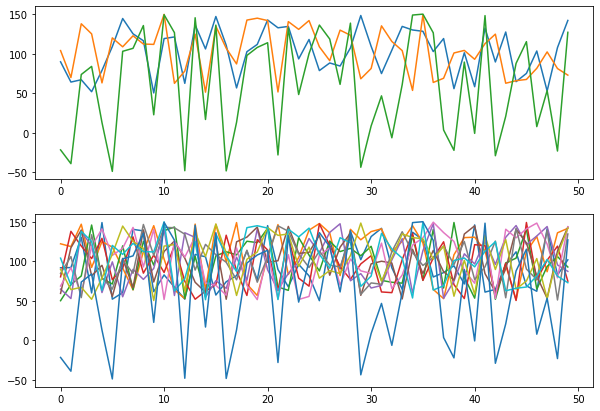

In [52]:
fig, axs = plt.subplots(2, figsize=(10, 7))
axs[0].plot(train_f_data.iloc[:50, -3:]);
axs[1].plot(train_f_data.iloc[:50]);

### conclusion: no obvious evidence of structure or pattern

### So more EDA!

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [54]:
train_data_ss = StandardScaler().fit_transform(train_f_data)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(train_data_ss[:,:10])
principalDf = pd.DataFrame(data=principalComponents
             , columns=['principal component 1', 'principal component 2', 'principal component 3'])
finalDf = pd.concat([principalDf, pd.Series(train_data_ss[:,10])], axis=1)

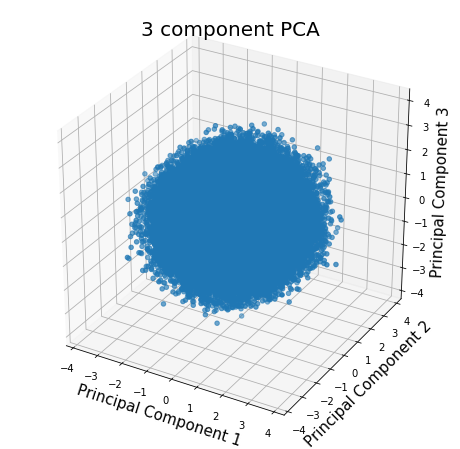

In [55]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_zlabel('Principal Component 3', fontsize=15)
ax.set_title('3 component PCA', fontsize=20)

ax.scatter(finalDf.iloc[:,0], finalDf.iloc[:,1], finalDf.iloc[:,2])

### spherical data, nasty!

In [56]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(train_data_ss[:,:10])
var = pca.explained_variance_ratio_
var

array([0.1014454 , 0.10098817, 0.1006058 , 0.10023283, 0.10006212,
       0.09987636, 0.09983089, 0.09925871, 0.09899871, 0.098701  ])

3.129157990114277


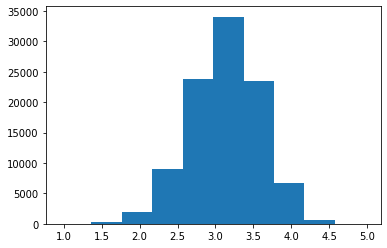

In [57]:
norms = np.linalg.norm(train_data_ss[:,:10], axis=1)
print(np.mean(norms))
plt.hist(norms);

### data is a hyper-shell

Since data is a shell, the higher-order curvilinear components are likely to be important. Or we could use polar coordinates, but polar has issues with CNN's since CNN operations don't respect the topology of polar coords, eg. f(0) = f(2pi). So we'll use curved components, eg. x1x2, x1x2x3, etc, to start with.

## Construct curvilinear components, go to 3rd order

I also tried 4th order but didnt seem to improve performance

In [58]:
del train_f_data['Y']

for k in range(10):
    for j in range(k+1):
        train_f_data.insert(train_f_data.shape[1], str(k)+'_'+str(j), value=train_f_data.iloc[:,k] * train_f_data.iloc[:,j])

for k in range(10):
    for j in range(k+1):
        for i in range(j+1):
            train_f_data.insert(train_f_data.shape[1], str(k)+'_'+str(j)+'_'+str(i), 
                        value=train_f_data.iloc[:,k] * train_f_data.iloc[:,j] * train_f_data.iloc[:,i])
            
train_f_data.insert(train_f_data.shape[1], 'Y', value=Ys)

In [59]:
train_f_data.head()[:3]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,9_9_1,9_9_2,9_9_3,9_9_4,9_9_5,9_9_6,9_9_7,9_9_8,9_9_9,Y
0,91.702200,122.032449,50.011437,80.233257,64.675589,59.233859,68.626021,84.556073,89.676747,103.881673,...,1.316901e+06,5.396935e+05,8.658293e+05,6.979403e+05,6.392164e+05,7.405710e+05,9.124786e+05,9.677378e+05,1.121029e+06,-21.800200
1,91.919451,118.521950,70.445225,137.811744,52.738759,117.046751,91.730480,105.868983,64.038694,69.810149,...,5.776116e+05,3.433118e+05,6.716196e+05,2.570201e+05,5.704223e+05,4.470445e+05,5.159479e+05,3.120898e+05,3.402168e+05,-39.223082
2,130.074457,146.826158,81.342418,119.232262,137.638915,139.460666,58.504421,53.905478,66.983042,137.814250,...,2.788635e+06,1.544918e+06,2.264551e+06,2.614144e+06,2.648744e+06,1.111161e+06,1.023814e+06,1.272193e+06,2.617474e+06,73.609137


In [60]:
del val_f_data['Y']

for k in range(10):
    for j in range(k+1):
        val_f_data.insert(val_f_data.shape[1], str(k)+'_'+str(j), value=val_f_data.iloc[:,k] * val_f_data.iloc[:,j])

for k in range(10):
    for j in range(k+1):
        for i in range(j+1):
            val_f_data.insert(val_f_data.shape[1], str(k)+'_'+str(j)+'_'+str(i), 
                        value=val_f_data.iloc[:,k] * val_f_data.iloc[:,j] * val_f_data.iloc[:,i])
            
val_f_data.insert(val_f_data.shape[1], 'Y', value=val_Ys)

In [61]:
val_f_data.head()[:3]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,9_9_1,9_9_2,9_9_3,9_9_4,9_9_5,9_9_6,9_9_7,9_9_8,9_9_9,Y
0,63.829641,119.347358,105.713332,68.373170,66.881433,74.710783,140.320621,58.642311,72.953643,62.044961,...,459436.871866,406951.635823,263207.798044,257465.242345,287604.929781,540175.069871,225748.105682,280840.683042,238846.871527,-32.820703
1,85.586246,101.381380,98.264544,89.474564,130.955658,107.674035,56.271685,112.086977,113.724524,83.367641,...,704617.176784,682954.657139,621862.856825,910163.248070,748352.160309,391097.419439,779022.826859,790404.046695,579418.747910,10.794890
2,148.698880,115.863627,67.484497,139.679959,75.304421,132.230822,149.409869,134.928236,110.463678,61.968953,...,444933.842140,259150.668133,536392.157864,289180.360916,507786.343147,573756.480162,518144.823664,424197.219993,237970.147403,145.096716


## Setup Data-batching,  Neural Net

In [66]:
Debug = False

class RegressionDataset(Dataset):
    def __init__(self, train_file, val_file=None):
        all_data = train_file
        inds = list(range(285)) + [285]
        self.min_max_scaler = preprocessing.MinMaxScaler()
        self.min_max_scaler.fit(all_data.iloc[:,inds].values)
        xy_scaled = self.min_max_scaler.transform(all_data.iloc[:,inds].values)
        all_data_scaled = pd.DataFrame(xy_scaled)
        
        self.X_data = torch.tensor(all_data_scaled.iloc[:,:-1].values, dtype=torch.float)
        self.Y_data = torch.tensor(all_data_scaled.iloc[:,-1].values, dtype=torch.float)
        
        # Debug mode allows to compare to simple Linear Regression, this helped debug NN
        if Debug:
            reg = LinearRegression().fit(all_data_scaled.iloc[:,:-1], all_data_scaled.iloc[:,-1])
            print(reg.score(all_data_scaled.iloc[:,:-1], all_data_scaled.iloc[:,-1]))
            print(metrics.mean_absolute_error(reg.predict(all_data_scaled.iloc[:,:-1]), all_data_scaled.iloc[:,-1]))
            print(metrics.mean_squared_error(reg.predict(all_data_scaled.iloc[:,:-1]), all_data_scaled.iloc[:,-1]))
            set_trace()
        
        if val_file:
            val_data = val_file
            val_xy_scaled = self.min_max_scaler.transform(val_data.iloc[:,inds].values)
            val_data_scaled = pd.DataFrame(val_xy_scaled)

            self.val_X_data = torch.tensor(val_data_scaled.iloc[:,:-1].values, dtype=torch.float)
            self.val_Y_data = torch.tensor(val_data_scaled.iloc[:,-1].values, dtype=torch.float)
        
    def __getitem__(self, index):
        x_data = self.X_data[index]
        y_data = self.Y_data[index]
        return x_data, y_data
        
    def __len__ (self):
        return self.X_data.shape[0]

In [67]:
kwargs = {'batch_size': 768, 'shuffle': False}
train_set = RegressionDataset(train_f_data) 
train_loader = torch.utils.data.DataLoader(train_set, **kwargs)
val_set = RegressionDataset(val_f_data)
val_loader = torch.utils.data.DataLoader(val_set, **kwargs)
dataiter = iter(train_loader)
data, target = dataiter.next()
#data, target

In [68]:
no_cuda = False
seed = 1
log_interval = 0
dry_run = False

use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

### Define Neural Net

It has 5-layers of linear NN, with ReLU non-linearity. The architecture was determined empirically, so it is not rigorously optimized

In [69]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 285)
        self.layer_2 = nn.Linear(285, 70)
        self.layer_3 = nn.Linear(70, 17)
        self.layer_4 = nn.Linear(17, 4)
        self.layer_out = nn.Linear(4, 1)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.layer_out(x)
        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

In [92]:
num_features = 285
epochs = 50
criterion = nn.MSELoss()
model = MultipleRegression(num_features).to(device)
params = [{'params': model.parameters(), 'lr': 0.001}]
optimizer = optim.Adam(params, eps=1e-07)      
ep_loss = []; val_ep_loss = [];
cur_best_val_loss = np.inf
save_model = False
save_path = 'd:/Users/user/Downloads/ml_tests-main_(1)/ml_tests-main/best_val_loss.pth'
generate_test_pred = True

## Train NN

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tMSE Loss: {:.3f}'.format(
            epoch, batch_idx * len(data), len(train_set),
            100. * batch_idx / len(train_set), loss.item()))
        print()
    
    ep_loss.append(running_loss / (batch_idx + 1))
    print('[%d, %5d] MSE Loss: %.3f' %
                (epoch + 1, batch_idx + 1, running_loss / (batch_idx + 1)))
    print()
    
    with torch.no_grad():
        val_epoch_loss = 0
        model.eval()
        
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            val_epoch_loss += val_loss.item()
        
        val_ep_loss.append(val_epoch_loss / len(val_loader))
        print('[%d] Val MSE Loss: %.3f' %
                (epoch + 1, val_epoch_loss / len(val_loader)))
        print()
        
        # save best model, if option selected
        if (epoch > 5) and (val_ep_loss[-1] < cur_best_val_loss):
            cur_best_val_loss = val_ep_loss[-1]
            best_ep = epoch
            if save_model:
                torch.save(model.state_dict(), save_path)
                
plt.plot(ep_loss, label='loss')
plt.plot(val_ep_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.ylim([0.0, 0.1])
plt.legend(loc='lower right')

### Calc MAE on Val set and optionally generate test_pred.csv file

In [106]:
model.load_state_dict(torch.load(save_path))
if generate_test_pred:
    f = open('d:/Users/user/Downloads/ml_tests-main_(1)/ml_tests-main/test_pred.csv','a')
    f.write('Y\n')

with torch.no_grad():
    val_total_AE = 0
    total_no = 0
    model.eval()

    for X_val_batch, y_val_batch in val_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
        y_val_pred = model(X_val_batch)
        # un-standardise
        Y_pred = train_set.min_max_scaler.inverse_transform(torch.cat([X_val_batch, y_val_pred], 1))
        Y_val = train_set.min_max_scaler.inverse_transform(torch.cat([X_val_batch, y_val_batch.unsqueeze(1)], 1))
        assert(Y_pred.shape[0] == Y_val.shape[0])
        val_total_AE += np.sum(np.abs(Y_pred[:,-1] - Y_val[:,-1]))
        total_no += Y_pred.shape[0]
        if generate_test_pred:
            np.savetxt(f, Y_pred[:,-1], fmt='%1.10f')
    if generate_test_pred:
        f.close()
        
    print()
    print("MAE on validation set: %.3f" % (val_total_AE / total_no))


MAE on validation set: 1.327
